In [30]:
!pip install qiskit qiskit-aer matplotlib --quiet

import math
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError

In [31]:
#Utility Functions
def plot_counts(counts, title="Counts", top_n=12):
    if not counts:
        print("No counts to plot.")
        return
    items = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)[:top_n]
    labels = [k for k, _ in items]
    vals = [v for _, v in items]
    plt.figure(figsize=(max(6, 0.6 * len(labels)), 3.5))
    plt.bar(labels, vals)
    plt.title(title)
    plt.xlabel("bitstring (classical)")
    plt.ylabel("counts")
    plt.show()

def most_likely(counts):
    return max(counts.items(), key=lambda kv: kv[1])[0] if counts else None

def matches_target(key, target):
    return key == target or key[::-1] == target


In [33]:
#Oracle and Diffuser Definitions
def mark_state_oracle(qc, qr, marked_bitstring):
    n = len(qr)
    for i, bit in enumerate(marked_bitstring):
        if bit == '0':
            qc.x(qr[i])
    if n == 1:
        qc.z(qr[0])
    else:
        qc.h(qr[-1])
        qc.mcx(qr[:-1], qr[-1])
        qc.h(qr[-1])
    for i, bit in enumerate(marked_bitstring):
        if bit == '0':
            qc.x(qr[i])

def diffuser(qc, qr):
    n = len(qr)
    qc.h(qr)
    qc.x(qr)
    if n == 1:
        qc.z(qr[0])
    else:
        qc.h(qr[-1])
        qc.mcx(qr[:-1], qr[-1])
        qc.h(qr[-1])
    qc.x(qr)
    qc.h(qr)


In [34]:
#Grover Circuit Builder
def grover_circuit(n, marked, iterations=1, measure=True, draw_gate=False):
    qr = QuantumRegister(n, 'q')
    cr = ClassicalRegister(n, 'c') if measure else None
    qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)

    qc.h(qr)
    for _ in range(iterations):
        mark_state_oracle(qc, qr, marked)
        diffuser(qc, qr)

    if measure:
        qc.measure(qr, cr)

    if draw_gate:
        print(qc.draw(output='text'))
    return qc

In [35]:
#Simulation Helpers
def run_ideal(qc, shots=1024):
    backend = AerSimulator()
    tc = transpile(qc, backend=backend)
    job = backend.run(tc, shots=shots)
    return job.result().get_counts()

def make_simple_noise_model(p1=0.002, p2=0.01, ro=0.03):
    nm = NoiseModel()
    single = depolarizing_error(p1, 1)
    two = depolarizing_error(p2, 2)
    nm.add_all_qubit_quantum_error(single, ['u3','u2','u1','h','x'])
    nm.add_all_qubit_quantum_error(two, ['cx'])
    nm.add_all_qubit_readout_error(ReadoutError([[1-ro, ro], [ro, 1-ro]]))
    return nm

def run_noisy(qc, noise_model, shots=2048):
    backend = AerSimulator()
    tc = transpile(qc, backend=backend)
    job = backend.run(tc, shots=shots, noise_model=noise_model)
    return job.result().get_counts()


🔹 Marked state = 001
     ┌───┐┌───┐     ┌───┐┌───┐┌───┐          ┌───┐┌───┐     ┌─┐      
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────┤M├──────
     ├───┤├───┤  │  ├───┤├───┤├───┤       │  ├───┤├───┤     └╥┘┌─┐   
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├───
     ├───┤├───┤┌─┴─┐├───┤├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
c: 3/════════════════════════════════════════════════════════╩══╩══╩═
                                                             0  1  2 


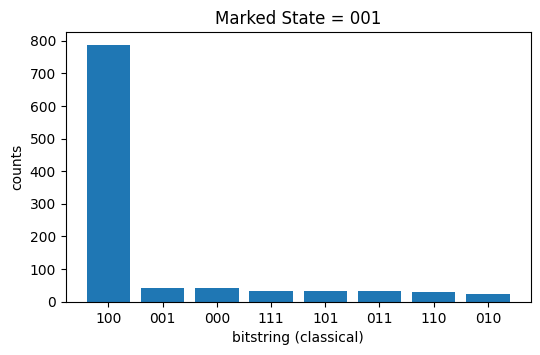


🔹 Marked state = 111
     ┌───┐          ┌───┐┌───┐               ┌───┐┌───┐     ┌─┐      
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────┤M├──────
     ├───┤       │  ├───┤├───┤            │  ├───┤├───┤     └╥┘┌─┐   
q_1: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────╫─┤M├───
     ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
c: 3/════════════════════════════════════════════════════════╩══╩══╩═
                                                             0  1  2 


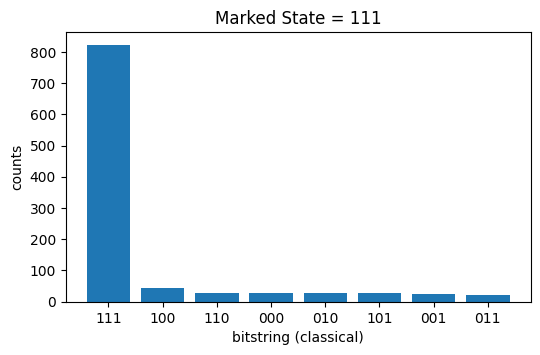


🔹 Marked state = 010
     ┌───┐┌───┐          ┌───┐┌───┐┌───┐               ┌───┐┌───┐     ┌─┐      
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────┤M├──────
     ├───┤└───┘       │  ├───┤├───┤└───┘            │  ├───┤├───┤     └╥┘┌─┐   
q_1: ┤ H ├────────────■──┤ H ├┤ X ├─────────────────■──┤ X ├┤ H ├──────╫─┤M├───
     ├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
c: 3/══════════════════════════════════════════════════════════════════╩══╩══╩═
                                                                       0  1  2 


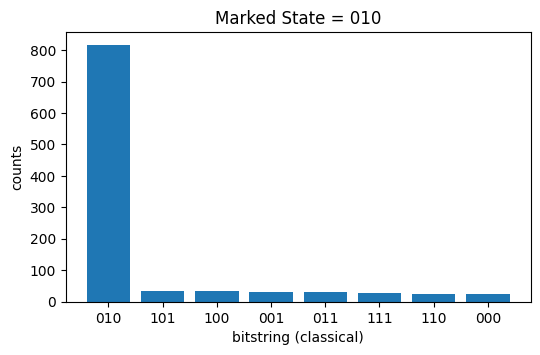

In [36]:
#Task 1 – Change Marked State
for state in ['001', '111', '010']:
    print(f"\n🔹 Marked state = {state}")
    qc = grover_circuit(3, state, iterations=1, draw_gate=True)
    counts = run_ideal(qc)
    plot_counts(counts, f"Marked State = {state}")


🔹 4-Qubit Grover Example (Marked = 0011)
     ┌───┐┌───┐     ┌───┐┌───┐┌───┐          ┌───┐┌───┐┌───┐          ┌───┐»
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├»
     ├───┤├───┤  │  ├───┤├───┤├───┤       │  ├───┤├───┤├───┤       │  ├───┤»
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├»
     ├───┤└───┘  │  ├───┤├───┤└───┘       │  ├───┤├───┤└───┘       │  ├───┤»
q_2: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤»
q_3: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 4/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐┌───┐          ┌───┐┌───┐     ┌─┐         
«q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────┤M├─────────
«  

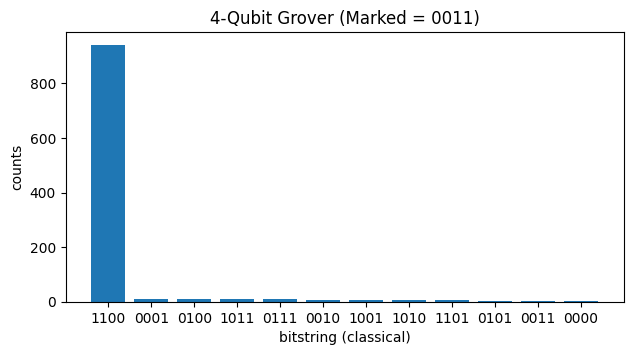

In [37]:
#Task 2 – Modify Number of Qubits (4-qubit)
print("\n🔹 4-Qubit Grover Example (Marked = 0011)")
qc = grover_circuit(4, '0011', iterations=2, draw_gate=True)
counts = run_ideal(qc)
plot_counts(counts, "4-Qubit Grover (Marked = 0011)")


🔹 Iterations = 1
     ┌───┐          ┌───┐┌───┐               ┌───┐┌───┐     ┌─┐      
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├─────┤M├──────
     ├───┤       │  ├───┤├───┤            │  ├───┤├───┤     └╥┘┌─┐   
q_1: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├──────╫─┤M├───
     ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
c: 3/════════════════════════════════════════════════════════╩══╩══╩═
                                                             0  1  2 


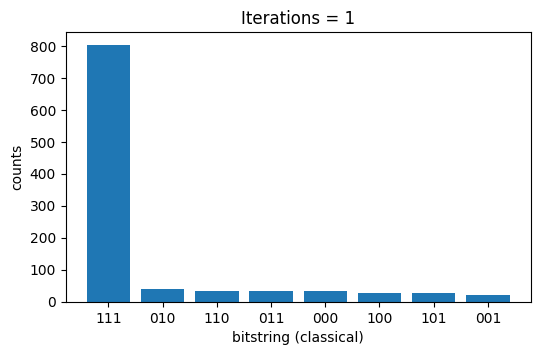


🔹 Iterations = 2
     ┌───┐          ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐»
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤»
q_1: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤»
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐               ┌───┐┌───┐     ┌─┐      
«q_0: ┤ X ├────────────■──┤ X ├┤ H ├─────┤M├──────
«     ├───┤            │  ├───┤├───┤     └╥┘┌─┐   
«q_1: ┤ X ├────────────■──┤ X ├┤ H ├──────╫─┤M├───
«     ├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
«q_2: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X

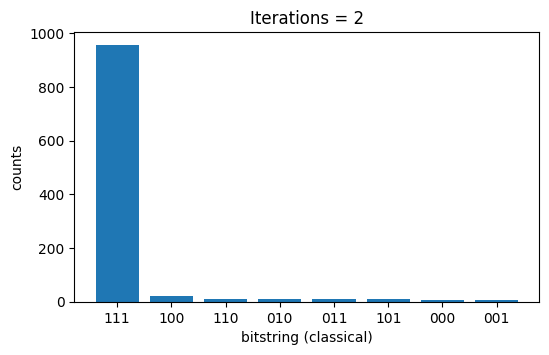


🔹 Iterations = 3
     ┌───┐          ┌───┐┌───┐               ┌───┐┌───┐               ┌───┐»
q_0: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤       │  ├───┤├───┤            │  ├───┤├───┤            │  ├───┤»
q_1: ┤ H ├───────■──┤ H ├┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├»
     ├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤┌───┐┌───┐┌─┴─┐├───┤»
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├»
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘»
c: 3/══════════════════════════════════════════════════════════════════════»
                                                                           »
«     ┌───┐               ┌───┐┌───┐               ┌───┐┌───┐               »
«q_0: ┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H ├┤ X ├────────────■──»
«     ├───┤            │  ├───┤├───┤            │  ├───┤├───┤            │  »
«q_1: ┤ X ├────────────■──┤ X ├┤ H ├────────────■──┤ H 

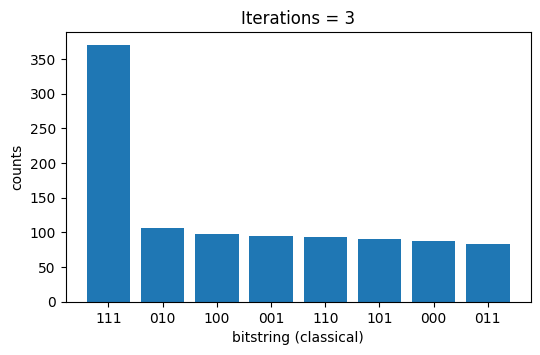

In [38]:
#Task 3 – Multiple Iterations
for i in [1, 2, 3]:
    print(f"\n🔹 Iterations = {i}")
    qc = grover_circuit(3, '111', iterations=i, draw_gate=True)
    counts = run_ideal(qc)
    plot_counts(counts, f"Iterations = {i}")


🔹 Ideal vs Noisy Comparison for marked=001
     ┌───┐┌───┐     ┌───┐┌───┐┌───┐          ┌───┐┌───┐     ┌─┐      
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────┤M├──────
     ├───┤├───┤  │  ├───┤├───┤├───┤       │  ├───┤├───┤     └╥┘┌─┐   
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├┤ X ├───────■──┤ X ├┤ H ├──────╫─┤M├───
     ├───┤├───┤┌─┴─┐├───┤├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐ ║ └╥┘┌─┐
q_2: ┤ H ├┤ H ├┤ X ├┤ H ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫──╫─┤M├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║  ║ └╥┘
c: 3/════════════════════════════════════════════════════════╩══╩══╩═
                                                             0  1  2 


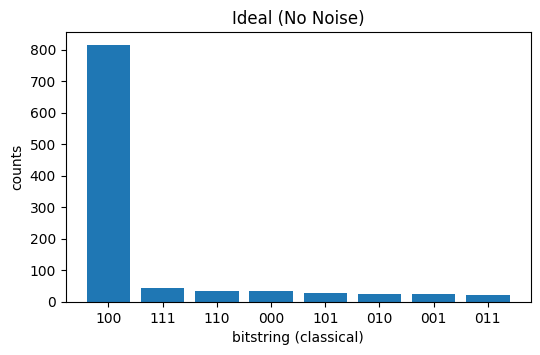

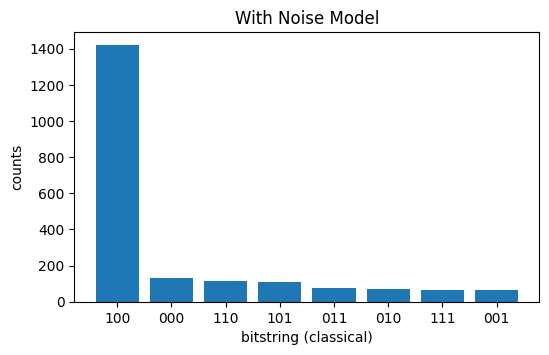

In [39]:
#Task 4 – Noise Experiment
noise_model = make_simple_noise_model()

print("\n🔹 Ideal vs Noisy Comparison for marked=001")
qc = grover_circuit(3, '001', iterations=1, draw_gate=True)

counts_ideal = run_ideal(qc)
plot_counts(counts_ideal, "Ideal (No Noise)")

counts_noisy = run_noisy(qc, noise_model)
plot_counts(counts_noisy, "With Noise Model")

In [ ]:
#Task 5 – (OPTIONAL) IBM Runtime Snippet
"""
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
service = QiskitRuntimeService()
backend = service.backend('ibmq_qasm_simulator')

qc = grover_circuit(3, '010', iterations=1)
sampler = Sampler(backend=backend)
result = sampler.run([qc]).result()
print(result)
"""